# Predicting the Presence of Heart Disease Using KNN Classifiers
Predictive question: Can we predict whether a person in Switzerland has heart disease based on their health condition data from the [Heart Disease dataset]("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data")?

## Introduction
TODO:

## Preliminary Exploratory Data Analysis
### Data Import and Inspection

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#DEMONSTRATING THAT THE DATA CAN BE READ

#Read in data
swiss_dataset <- read.csv(file = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", header = F)

#Prepare column names
names <- c("age",
           "sex",
           "cp",
           "trestbps",
           "chol",
           "fbs",
           "restecg",
           "thalach",
           "exang",
           "oldpeak",
           "slope",
           "ca",
           "thal",
           "num")

#Apply column names to the dataframe
colnames(swiss_dataset) <- names

In [3]:
swiss_dataset

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
32,1,1,95,0,?,0,127,0,.7,1,?,?,1
34,1,4,115,0,?,?,154,0,.2,1,?,?,1
35,1,4,?,0,?,0,130,1,?,?,?,7,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,?,2,114,0,1.6,2,2,?,0
73,0,3,160,0,0,1,121,0,0,1,?,3,1
74,1,2,145,0,?,1,123,0,1.3,1,?,?,1


### Data Cleaning and Wrangling
From the dataset above, we can see missing values that are represented by question marks (?). Since we only get a brief view into how many observations have missing values, we will have to calculate the number of rows with missing values as shown below.

Prior to this, we have to replace all the ? values with NA values so that further processing steps can be made easier

In [4]:
for (col_name in names(swiss_dataset)) {
        swiss_dataset[, col_name][swiss_dataset[, col_name] == "?"] <- NA
    }

In [5]:
swiss_dataset

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
32,1,1,95,0,NA,0,127,0,.7,1,NA,NA,1
34,1,4,115,0,NA,NA,154,0,.2,1,NA,NA,1
35,1,4,NA,0,NA,0,130,1,NA,NA,NA,7,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,NA,2,114,0,1.6,2,2,NA,0
73,0,3,160,0,0,1,121,0,0,1,NA,3,1
74,1,2,145,0,NA,1,123,0,1.3,1,NA,NA,1


We will tally the count of missing (NA) values in each column to determine its suitability for use. We will express this value as a percentage of the total number of observations we have in our dataframe.

In [6]:
result <- swiss_dataset %>%
  summarize(across(everything(), ~sum(is.na(.))))
result

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,2,0,75,1,1,1,6,17,118,52,0


From the summary above, we can see that the fbs, ca and thal columns have the most number of NA values, making them improper for use in further classification and training sets. Because of this, we will remove these columns and focus our exploratory analysis on the remaining columns

In [7]:
removed_cols_swiss_dataset <- swiss_dataset |>
                                select(-fbs, -ca, -thal)
removed_cols_swiss_dataset

age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,num
<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
32,1,1,95,0,0,127,0,.7,1,1
34,1,4,115,0,NA,154,0,.2,1,1
35,1,4,NA,0,0,130,1,NA,NA,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,2,114,0,1.6,2,0
73,0,3,160,0,1,121,0,0,1,1
74,1,2,145,0,1,123,0,1.3,1,1


Now that we have removed those columns, we can now calculate the average statistics per heart rate severity. i.e. when num = 1, we calculate all the average values from each variable for every observation where num = 1. Before doing this, we have to convert each variable's data type to an integer instead of a character.

In [8]:
for (col in 1:ncol(removed_cols_swiss_dataset)) {
  removed_cols_swiss_dataset[, col] <- as.integer(as.character(removed_cols_swiss_dataset[, col]))
}

removed_cols_swiss_dataset

age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,num
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
32,1,1,95,0,0,127,0,0,1,1
34,1,4,115,0,NA,154,0,0,1,1
35,1,4,NA,0,0,130,1,NA,NA,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,2,114,0,1,2,0
73,0,3,160,0,1,121,0,0,1,1
74,1,2,145,0,1,123,0,1,1,1


### Data Summarization
Now that we have converted all the columns to integer data types, we can now carry out our summary analysis

In [9]:
summary_analysis <- removed_cols_swiss_dataset |>
                    group_by(num) |>
                    summarize_all(.funs = list(mean = ~mean(., na.rm = TRUE)))
summary_analysis

num,age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,54.62500,1.0000000,3.000000,124.3750,0,0.5000000,136.6250,0.1250000,0.3750000,1.750000
1,55.62500,0.8750000,3.666667,127.2917,0,0.2765957,125.3542,0.4583333,0.2765957,1.853659
2,52.62500,0.9062500,3.750000,130.0000,0,0.4062500,126.4062,0.3750000,0.6451613,1.758621
3,58.43333,0.9666667,3.833333,138.9286,0,0.4000000,107.7931,0.5862069,0.8076923,1.826087
4,52.00000,1.0000000,4.000000,120.0000,0,0.4000000,109.8000,0.4000000,0.8000000,1.600000


From this summary analysis, we can infer statistics for each column. However, one outlier is the chol_mean column, which shows the average serum cholesterol in a person's blood. Since most of the values in the previous tables are zero, and the average for each heart condition is also zero, it would be a suitable idea to remove this column since it provides no further insight into the heart conditions, and will only be extra uneccessary computation when training models. Because of this, it will be removed.

In [10]:
removed_cols2_swiss_dataset <- removed_cols_swiss_dataset |>
                                select(-chol)
removed_cols2_swiss_dataset

age,sex,cp,trestbps,restecg,thalach,exang,oldpeak,slope,num
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
32,1,1,95,0,127,0,0,1,1
34,1,4,115,NA,154,0,0,1,1
35,1,4,NA,0,130,1,NA,NA,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,2,114,0,1,2,0
73,0,3,160,1,121,0,0,1,1
74,1,2,145,1,123,0,1,1,1


##### [Repeat of the summary analysis]

In [11]:
summary_analysis

num,age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,54.62500,1.0000000,3.000000,124.3750,0,0.5000000,136.6250,0.1250000,0.3750000,1.750000
1,55.62500,0.8750000,3.666667,127.2917,0,0.2765957,125.3542,0.4583333,0.2765957,1.853659
2,52.62500,0.9062500,3.750000,130.0000,0,0.4062500,126.4062,0.3750000,0.6451613,1.758621
3,58.43333,0.9666667,3.833333,138.9286,0,0.4000000,107.7931,0.5862069,0.8076923,1.826087
4,52.00000,1.0000000,4.000000,120.0000,0,0.4000000,109.8000,0.4000000,0.8000000,1.600000


From the summary above, we can see that as num increases - meaning that the heart condition becomes more severe - the average chest pain type (cp_mean) increases in value, going from non-anginal pain to asymptomatic. 

Furthermore, another value that increases as the heart condition worsens is the ST depression induced by exercise relative to rest (oldpeak_mean). This value would not matter for people with no heart condition, but for 1 <= num <= 4, there seems to be an increase.

Another value that actually decreases on average when num increases is the maximum heart rate (thalach_mean).

There are other variables that can also be seen increasing or decreasing, but their differences are neglible compared to the ones we have already stated above.

Now that we have a good idea of what variables we can focus on, we will now produce visualizations using the overall clean dataset to support our initial observations.

Prior to this, we'll split the data into training data and testing data.

In [12]:
cleaned_data <- removed_cols2_swiss_dataset |> mutate(num = as_factor(num))

data_split <- initial_split(cleaned_data, prop = 0.75, strata = num) 
data_train <- training(data_split)
data_test <- testing(data_split)

### Data Visualization
We'll repeat the same summary analysis on just our training data to confirm the patterns from before

In [13]:
training_summary_analysis <- removed_cols2_swiss_dataset |>
                    group_by(num) |>
                    summarize_all(.funs = list(mean = ~mean(., na.rm = TRUE)))
training_summary_analysis

num,age_mean,sex_mean,cp_mean,trestbps_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,54.62500,1.0000000,3.000000,124.3750,0.5000000,136.6250,0.1250000,0.3750000,1.750000
1,55.62500,0.8750000,3.666667,127.2917,0.2765957,125.3542,0.4583333,0.2765957,1.853659
2,52.62500,0.9062500,3.750000,130.0000,0.4062500,126.4062,0.3750000,0.6451613,1.758621
3,58.43333,0.9666667,3.833333,138.9286,0.4000000,107.7931,0.5862069,0.8076923,1.826087
4,52.00000,1.0000000,4.000000,120.0000,0.4000000,109.8000,0.4000000,0.8000000,1.600000


##### The same trends are present here as before, so now we will do our data visualizations for these variables compared to others.

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


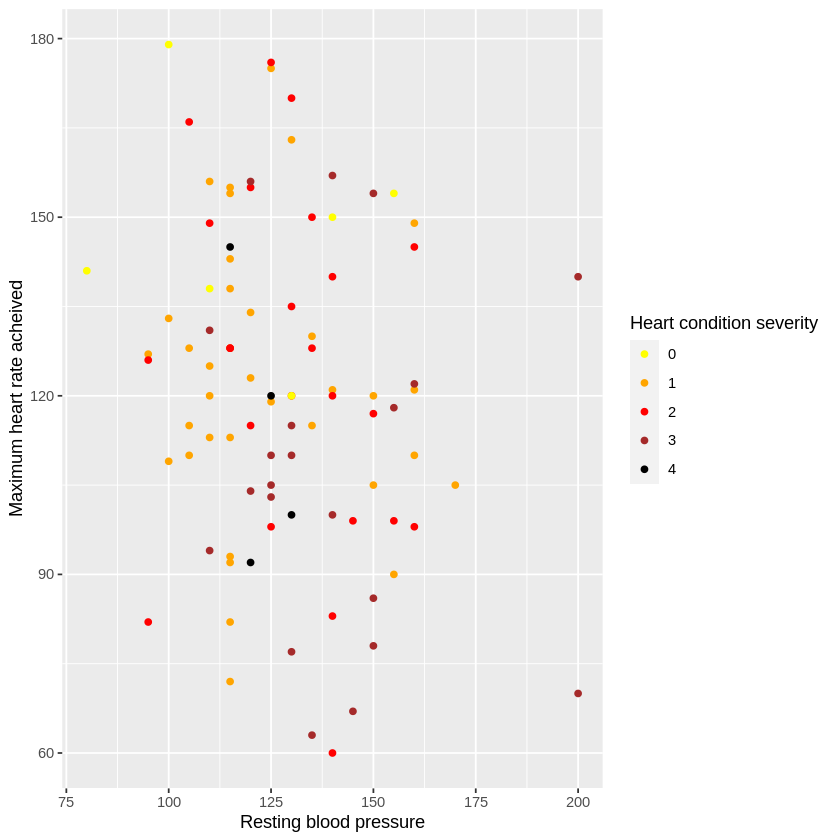

In [14]:
heart_rate_graph <- data_train |>
                ggplot(aes(x = trestbps, y = thalach, color = num)) +
                geom_point() +
                
                labs(x = "Resting blood pressure", y = "Maximum heart rate acheived", color = "Heart condition severity") +
                scale_color_manual(values = c("0" = "yellow", "1" = "orange", "2" = "red", "3" = "brown", "4" = "black"))
            
heart_rate_graph

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


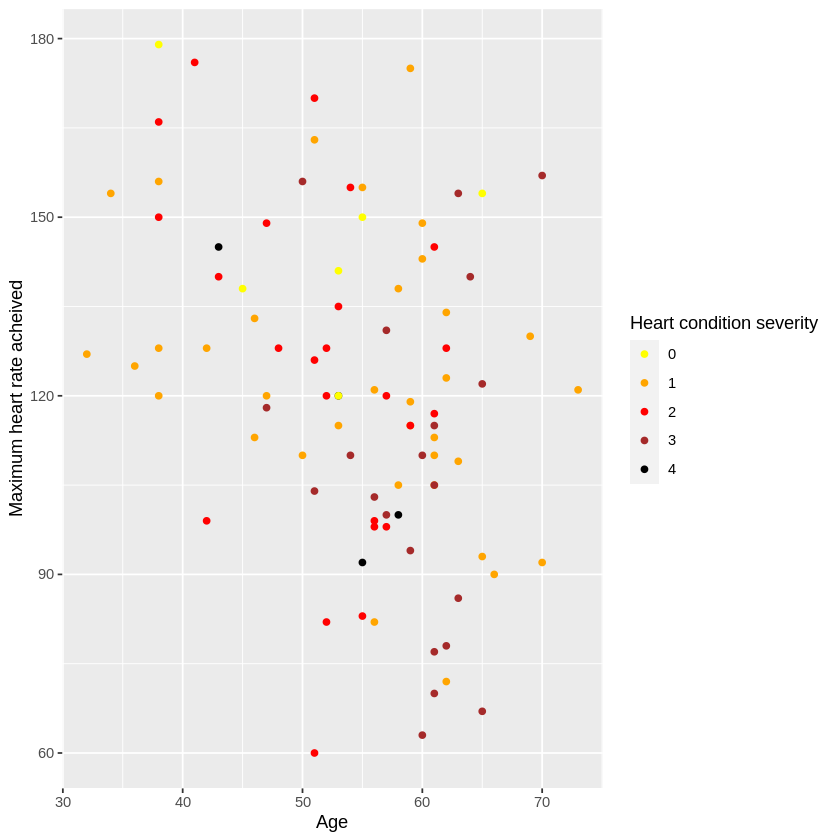

In [15]:
age_graph <- data_train |>
                ggplot(aes(x = age, y = thalach, color = num)) +
                geom_point() +
                
                labs(x = "Age", y = "Maximum heart rate acheived", color = "Heart condition severity") +
                scale_color_manual(values = c("0" = "yellow", "1" = "orange", "2" = "red", "3" = "brown", "4" = "black"))
            
age_graph

## Methods

### KNN Classifier
The K-nearest neighbors classifier uses the K(a number picked that gives us the best accuracy) “nearest” or “most similar” observations in our training set and then uses their diagnoses to make a prediction for the new observation’s diagnosis. By using KNN, we classify whether a person has heart disease or not.

### KNN Specification
We chose age_mean, sex_mean, cp_mean, trestbps_mean, restecg_mean, thalach_mean, exang_mean, oldpeak_mean, slope_mean these 9 variables to predict the num variable. Because these 9 factors have close relationship with health of the heart as we disscussed in the Data Summarization section above.

To avoid one variable becoming dominant in KNN distance computation, we use scaling and centering to standardize our data. In this way, two observation variables can be weighed equally while we calculating the distance in the KNN algorithm.

To get the optimal result for our KNN classifier, we will tune our model using accuracy as metric.

### Visualization
We plan to plot a scatter plot graph, with two kinds of color points based on whether the person has heart disease or not. The background will display the classifier's prediction with different color which demonstrating that the actual values align with the classifier's results. Additionally, we need to show accuracy, precision, and recall, numerically. 

## Expected outcomes and significance
**What do you expect to find?**

In this project, we expect to answer our predictive question that given a person's health condition from [Heart Disease dataset]("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"), can we predict whether a person has heart disease by applying KNN method.

**What impact could such findings have?**

The promising result for this project indicates the possibility that the method shown in our project can help healthcare professionals make informed decisions. The findings can also help develop predictive models to estimate future health risks based on the data we have which allows for early intervention and medical recommendations. 

**What future questions could this lead to?**

We would be interested in exploring how different health factors of a person impact the decision of the model. In particular, are there any other factors that could be significant for the model to make the decision? Is there any other model that works better than KNN in this task? They could also lead to potential implications for healthcare resource allocation and cost-effective interventions. 